**UNET- Semantic Segmentation Model Training Implementation**

**Step 1:** Configure Dataset Filepaths & Load functions

In [1]:
import os
import glob

# Replace the "home/username/dev/" with your own directory path
work_dir= "/home/aazam/dev" + "/Visual-Saliency-Prediction-UNET-Model/"
# Verify image paths
if not os.path.exists(work_dir):
    print(f"Path does not exist: {work_dir}")
else:
    print(f"Path exists: {work_dir}")

    # Create lists of image and mask file paths
    image_paths = glob.glob(work_dir + 'Dataset/Images/*.png')
    mask_paths = glob.glob(work_dir + 'Dataset/Masks/*.png')
    print('Total Images in Dataset:', len(image_paths))

    # Misc Paths
    pretrain_modelpath = work_dir + "Pre-trained_Model/"
    logpath = work_dir + 'Logs'
    os.makedirs(pretrain_modelpath, exist_ok=True)
    os.makedirs(logpath, exist_ok=True)

    # Create new name for Model which will be trained
    modelpath = pretrain_modelpath + 'unetmodel_v'+str(len(glob.glob(pretrain_modelpath + '/*.keras')))+'.keras'

# Resizing images is optional, since dataset image size is 256x256x3
SIZE_X = 128
SIZE_Y = 128

# Define your parameters
batch_size = 32
epochs = 30
num_data = len(image_paths)


Path exists: /home/aazam/dev/Visual-Saliency-Prediction-UNET-Model/
Total Images in Dataset: 13426


In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras" # Indicates that TensorFlow's Keras API  will be used for training
# os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

import tensorflow as tf
from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

# GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # tf.config.experimental.set_memory_growth(gpu, True)
        # tf.config.experimental.set_virtual_device_configuration(gpus[0], 
        #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Adjust memory limit as necessary
        
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found. Please check your TensorFlow installation and GPU setup.")

# Define the dataset loading and preprocessing function
def preprocess_stage(image_path, mask_path):
    # Load and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (SIZE_X, SIZE_Y))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    # Load and preprocess mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (SIZE_X, SIZE_Y))
    mask = tf.math.round(mask / 255.0) # Ensure mask values are either 0 or 1
    return image, mask

# Adopted U-Net model architecture from "segmentation_models" library
# Utilized ResNet34 as the backbone, used initial weights from pretrained network ImageNet (Transfer Learning)
def unet_model(input_shape):
    model = Unet(backbone_name='resnet34', input_shape=input_shape, encoder_weights='imagenet', classes=1, activation='sigmoid')
    model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])
    return model


1 Physical GPUs, 1 Logical GPUs


**Step 2:** Prepare & Split datasets to three batches sets (Training Set, Validation Set & Testing Set)

In [6]:
# Calculate the number of samples in each set
train_split = 0.6
validate_split = 0.3
test_split = 1-(train_split + validate_split)

num_train = int(train_split * num_data)
num_valid = int(validate_split * num_data)

# Convert your lists into TensorFlow Datasets
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

# Shuffle the dataset
dataset = dataset.shuffle(len(image_paths), seed=42)

# Split the dataset
dataset_train = dataset.take(num_train)
dataset_remaining = dataset.skip(num_train)
dataset_valid = dataset_remaining.take(num_valid)
dataset_test = dataset_remaining.skip(num_valid)

print('Load Dataset and prepare for training:')
print(f"Total Dataset Images: {num_data}",
      f"\nTrain Split Images ({round(train_split*100)}%) : {len(dataset_train)}",
      f"\nValidate Split Images ({round(validate_split*100)}%) : {len(dataset_valid)}",
      f"\nTest Split Images ({round(test_split*100)}%) : {len(dataset_test)}"
      )

# Apply your loading and preprocessing function
dataset_train = dataset_train.map(preprocess_stage)
dataset_valid = dataset_valid.map(preprocess_stage)
dataset_test = dataset_test.map(preprocess_stage)

# Batch the data
dataset_train = dataset_train.batch(batch_size)
dataset_valid = dataset_valid.batch(batch_size)
dataset_test = dataset_test.batch(batch_size)


# Prefetch for performance
dataset_train = dataset_train.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_valid = dataset_valid.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_test = dataset_test.prefetch(buffer_size=tf.data.AUTOTUNE)


Load Dataset and prepare for training:
Total Dataset Images: 13426 
Train Split Images (60%) : 8055 
Validate Split Images (30%) : 4027 
Test Split Images (10%) : 1344


**Step 3:** Train & Validate the Unet Model

Epoch 1/30


I0000 00:00:1717660985.634727  125180 service.cc:145] XLA service 0x7ff050003780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717660985.636442  125180 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2024-06-06 13:03:06.263669: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-06 13:03:08.762039: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
2024-06-06 13:03:18.435115: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[32,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,16,128,128]{3,2,1,0}, f32[16,16,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operati

251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - iou_score: 0.4599 - loss: 0.8182

2024-06-06 13:04:40.605939: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[23,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,16,128,128]{3,2,1,0}, f32[16,16,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-06-06 13:04:41.070735: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.464880697s
Trying algorithm eng4{k11=1} for conv (f32[23,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,16,128,128]{3,2,1,0}, f32[16,16,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"c

252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - iou_score: 0.4602 - loss: 0.8176
Epoch 1: val_loss improved from inf to 1.99517, saving model to /home/aazam/dev/Visual-Saliency-Prediction-UNET-Model/Pre-trained_Model/unetmodel_v3.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 149s 374ms/step - iou_score: 0.4606 - loss: 0.8170 - val_iou_score: 0.3699 - val_loss: 1.9952
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - iou_score: 0.6422 - loss: 0.5292
Epoch 2: val_loss improved from 1.99517 to 1.60902, saving model to /home/aazam/dev/Visual-Saliency-Prediction-UNET-Model/Pre-trained_Model/unetmodel_v3.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 54s 215ms/step - iou_score: 0.6422 - loss: 0.5292 - val_iou_score: 0.3085 - val_loss: 1.6090
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - iou_score: 0.6659 - loss: 0.4943
Epoch 3: val_loss improved from 1.60902 to 1.45200, saving model to /home/aazam/dev/Visual-Saliency-Prediction-UNET-Model/Pre-trained_Model/unetmodel_v3.keras
252/252 ━━━━━━━━━━━━━━━━━━

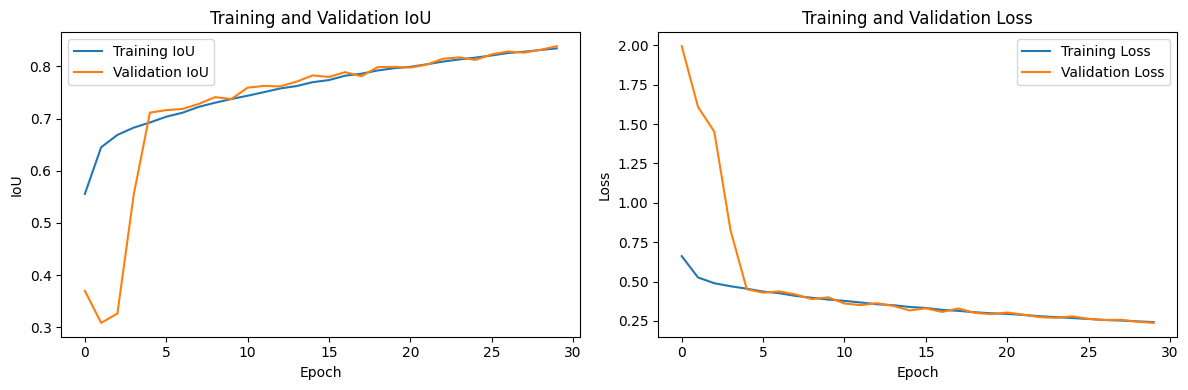

Trained Model has been stored:/home/aazam/dev/Visual-Saliency-Prediction-UNET-Model/Pre-trained_Model/unetmodel_v3.keras


In [7]:
import matplotlib.pyplot as plt
from tensorflow import keras

# Define model
input_shape = (SIZE_X, SIZE_Y, 3)  # Adjust based on the size of your images
model = unet_model(input_shape)

# Model Checkpoint - save model after every epochs
# Save Best only - latest best model will not be overwritten
checkpointer = tf.keras.callbacks.ModelCheckpoint(modelpath,verbose=1,save_best_only=True)

# Early Stopping - TensorBoard Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir= logpath),
    checkpointer
]

# Train the model
history = model.fit(dataset_train, 
                    validation_data = dataset_valid, 
                    epochs = epochs, 
                    callbacks = callbacks)

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['iou_score'], label='Training IoU')
plt.plot(history.history['val_iou_score'], label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
print(f"Trained Model has been stored:{modelpath}")

**Step 4:** Evaluate Test Dataset on the trained model

In [8]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Load the model
model = keras.models.load_model(modelpath, compile=False)
# Compile the model (make use of the same loss and metrics as used during training)
model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(dataset_test, verbose=2)

# Print the results
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

42/42 - 5s - 124ms/step - iou_score: 0.8387 - loss: 0.2357
Test loss: 0.23565131425857544
Test accuracy: 0.8387258648872375


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


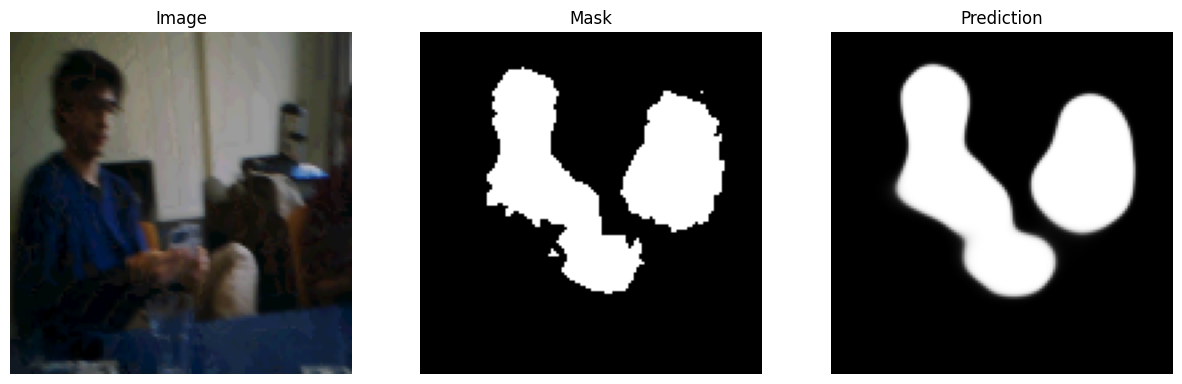

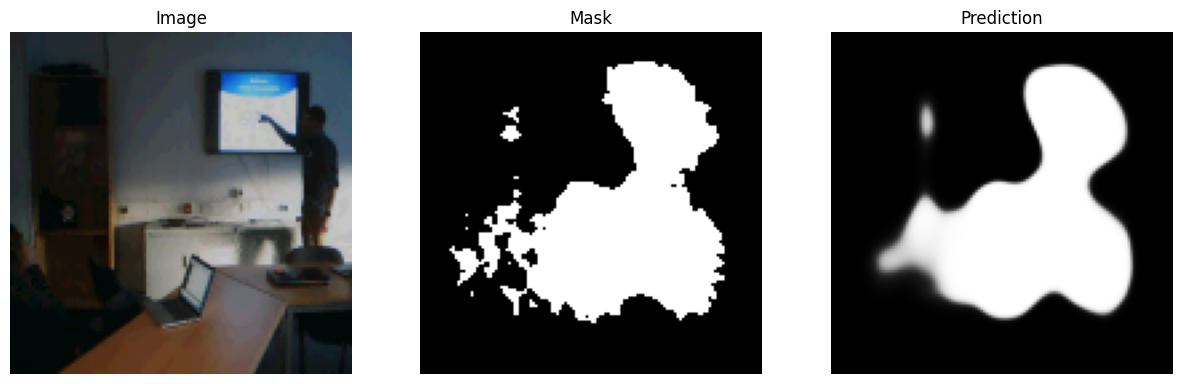

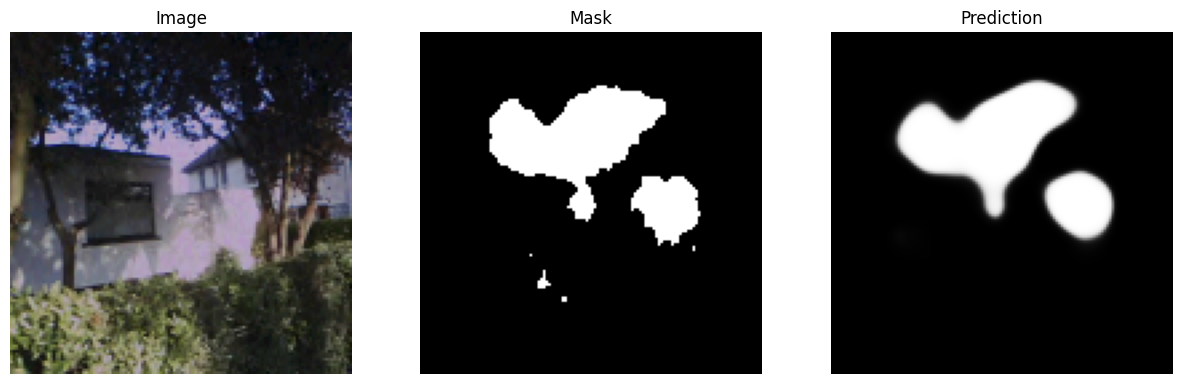

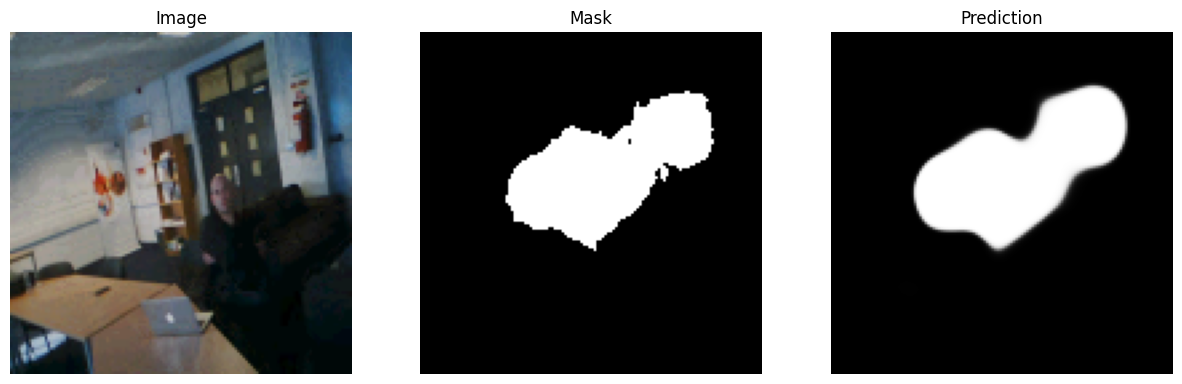

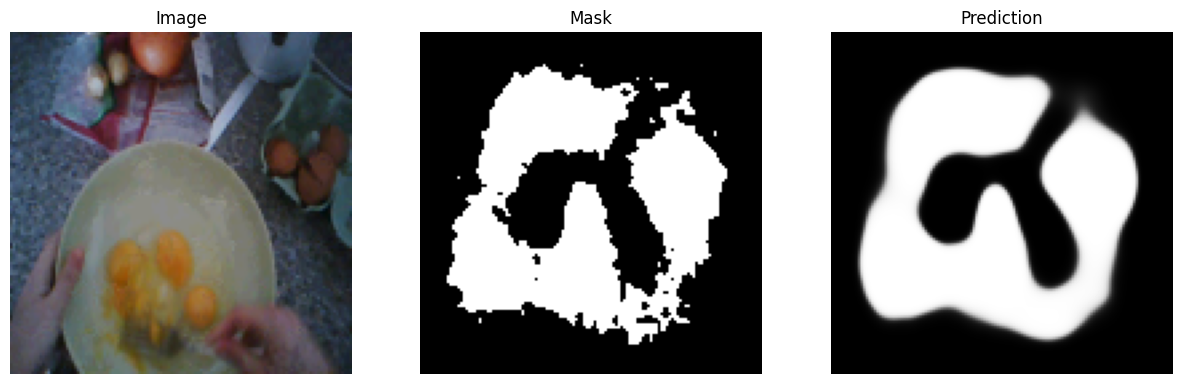

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to plot images, masks, and predictions
def plot_images(dataset, model, num_images=5):
    # Extract a batch of data
    sample_data, true_mask = next(iter(dataset))
     # Predict the labels for the sample data
    pred_mask = model.predict(sample_data)

    for i in range(num_images):
        plt.figure(figsize=(15, 5))
       
        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(tf.cast(sample_data[i]*255.0, tf.uint8))
        plt.title("Image")
        plt.axis('off')

        # Plot ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[i].numpy().squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        # Plot model prediction
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[i].squeeze(), cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

        plt.show()
    
    return true_mask, pred_mask

# Assuming model and dataset_test are defined earlier
# Plot images, masks, and predictions from the dataset
true_mask, pred_mask = plot_images(dataset_test, model)


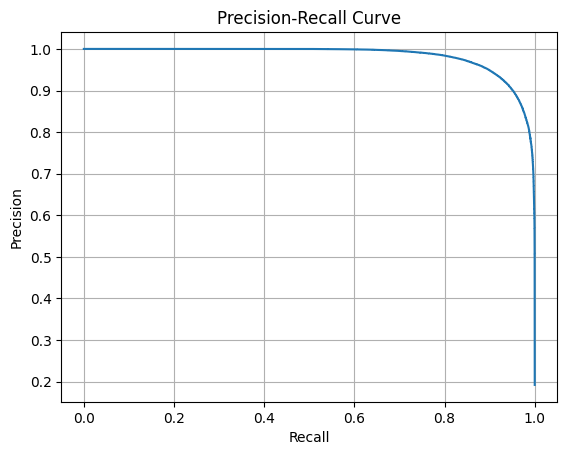

In [12]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Convert TensorFlow tensors to NumPy arrays
true_labels = true_mask.numpy().flatten()
predicted_labels = pred_mask.flatten()

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(true_labels, predicted_labels)

# Plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

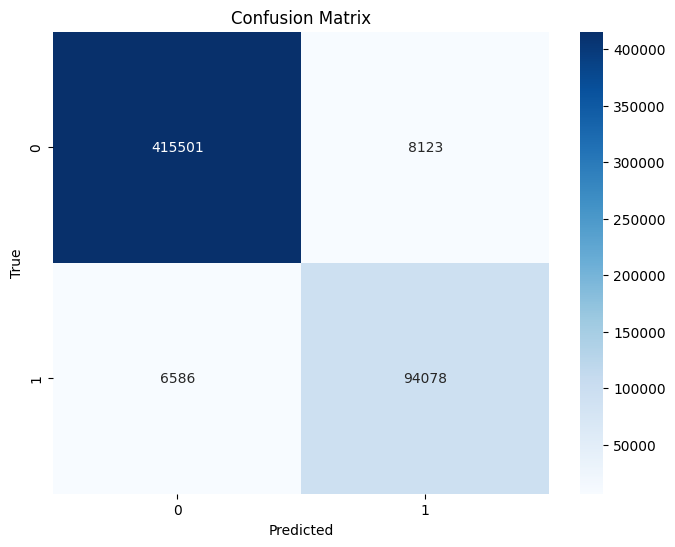


Trained Model Results:
Accuracy: 97%
Precision:  92%
Recall:  93%
F1 Score: 93%


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get confusion matrix for dataset_test
threshold = 0.5
# Convert true and predicted masks to binary arrays
true_mask_binary = np.where(true_mask > threshold, 1, 0)  # Assuming the threshold for binary segmentation is 0.5
pred_mask_binary = np.where(pred_mask > threshold, 1, 0)

# Reshape the binary arrays to 1D arrays
true_labels = true_mask_binary.flatten()
predicted_labels = pred_mask_binary.flatten()

# Compute the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Extract true positives, true negatives, false positives, and false negatives from the confusion matrix
tn, fp, fn, tp = confusion_mat.ravel()
# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # To avoid division by zero
recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # To avoid division by zero
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # To avoid division by zero
print('\nTrained Model Results:')
print(f"Accuracy: {round(accuracy*100)}%")
print(f"Precision:  {round(precision*100)}%")
print(f"Recall:  {round(recall*100)}%")
print(f"F1 Score: {round(f1*100)}%")